In [1]:
%load_ext autoreload
%autoreload 2

from typing import Any
import random
import os

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from validation_model import ValidationModel
from settings import *
from notebooks.avapix_model import AvapixModel
from avapix_utils import ProcessorV1_1, ProcessorV1_0
import utils

In [2]:
DEVICE = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print (f'Using device: {DEVICE}')

Using device: cuda


In [97]:
class AvapixLoss(nn.Module):
    def __init__(self, zero_limit_value: float = 0.01) -> None:
        super().__init__()

        self.zero_limit_value = zero_limit_value

    def __face_shape_loss(self, x: torch.Tensor):
        """
        Given the validity of the generated image, calculate the
        loss of the generated image. The loss is calculated by
        the following formula:

        loss = tan(1) / x - tan(x)

        Which starts from 0 when x = 0, and increases exponentially
        as x approaches 1. Therefore the zero_limit_value, limits
        the minimum value of x to be zero_limit_value.

        The total loss is calculated by taking the mean of the
        cubed loss of each generated image.
        """
        x = x.masked_fill(x < self.zero_limit_value, self.zero_limit_value)

        one_tensor = torch.tensor([1.0], device=self.device)
        loss = torch.tan(one_tensor) / x - torch.tan(x)
        loss = loss.pow(2).mean()

        return loss

    def __penalty_loss(self, output_img: torch.Tensor, org_img: torch.Tensor):
        """
        Penalize the output image embedded color images are not the same
        as the original image.
        """
        mask = org_img != 0

        result = torch.zeros_like(output_img)
        result[mask] = output_img[mask]

        loss = (result - org_img).pow(2).mean()

        return loss

    def forward(self, x: torch.Tensor, output_img: torch.Tensor, org_img: torch.Tensor):
        self.device = x.device

        loss = self.__face_shape_loss(x)
        # loss += self.__penalty_loss(output_img, org_img)

        return loss.requires_grad_(True)


In [163]:
class EmbeddedFacesDataset(Dataset):
    def __init__(self, num_samples, device) -> None:
        super().__init__()

        self.num_samples = num_samples
        self.device = device
        self.random_lengths = list(range(128))
        self.processor = ProcessorV1_1()
        self.chars = " !\"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"

    def __getitem__(self, _) -> Any:
        curr_rand_len = random.choice(self.random_lengths)

        choices = np.random.choice(list(self.chars), curr_rand_len)
        text = ''.join(choices)

        output_img = self.processor.embed(text)
        output_img = utils.numpy_to_tensor(output_img, self.device)

        return output_img

    def __len__(self):
        return self.num_samples


In [164]:
LEARNING_RATE = 0.00005
BATCH_SIZE = 16

total_epochs = 0

ds = EmbeddedFacesDataset(100_000, DEVICE)
dl = DataLoader(ds, BATCH_SIZE)

model = AvapixModel()
model.to(DEVICE)

criterion = AvapixLoss(1e-6)

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load("./checkpoints_vm/epoch-50.pth"))
loss_model.to(DEVICE)
loss_model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
losses = []

In [165]:
for epoch in range(10):
    model.train()
    total_loss = 0.0

    for batch_imgs in dl:
        optimizer.zero_grad()
        outputs = model(batch_imgs)

        face_loss = loss_model(outputs)
        loss = criterion(face_loss, batch_imgs, outputs)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dl)
    losses.append(avg_loss)

    print(f"Epoch {total_epochs + 1:02d} - Loss: {avg_loss:,.4f}", end="\t\t")
    if (total_epochs + 1) % 2 == 0:
        print()

    # save progress
    #   save checkpoint
    torch.save(model.state_dict(), f"./checkpoints_am/epoch-{total_epochs + 1}.pth")
    #   save model output
    img = utils.tensor_to_numpy(outputs[0])
    Image.fromarray(np.kron(img, np.ones((30, 30, 1))).astype(np.uint8)).save(
        f"./train_outputs/{total_epochs + 1:02d}.png"
    )

    total_epochs += 1

print("Training complete.")

Epoch 01 - Loss: 1,285,165.2735		Epoch 02 - Loss: 987,286.0903		
Epoch 03 - Loss: 934,395.4042		Epoch 04 - Loss: 911,715.3600		
Epoch 05 - Loss: 900,767.6960		Epoch 06 - Loss: 893,673.7298		
Epoch 07 - Loss: 886,724.5260		

KeyboardInterrupt: 

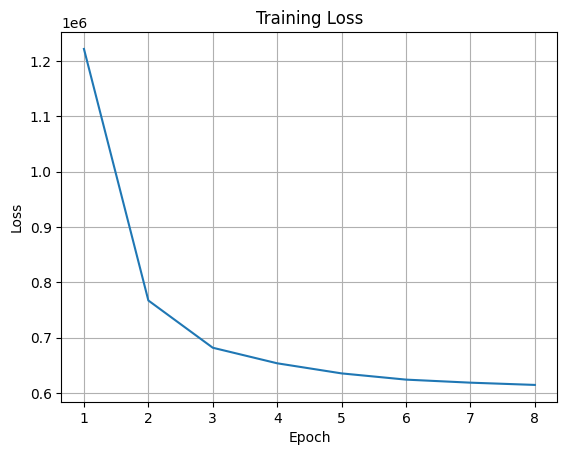

In [141]:
plt.plot(range(1, total_epochs + 1), losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Test Area
---

In [83]:
processor = ProcessorV1_1()
embedded_img = processor.embed('bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh')
input_img = utils.numpy_to_tensor(embedded_img, DEVICE).unsqueeze(0)

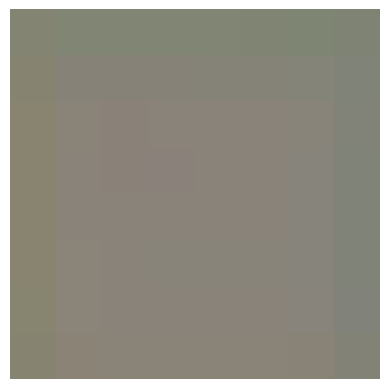

In [82]:
model.eval()
output_img = model(input_img)
utils.show_model_output_image(output_img)

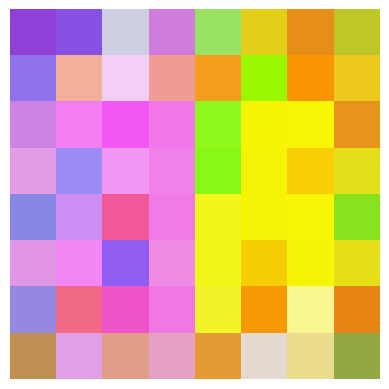

In [75]:
mask = input_img != 0
output_img[mask] = input_img[mask]

utils.show_model_output_image(output_img)

In [77]:
processor.extract(output_img.detach().cpu().squeeze().permute(1, 2, 0).mul(255).numpy().astype(np.uint8))

'|ò÷*cö\x04÷\x1a\x9dóâ\x1b\x9a°ôô\x17\x95\x19úñâåÄ\x05ôí\x03B\x86\x8fóð\x05Ïäó\x95Íç\x04Sqä\x92\x96ñ\x04ã\x8eÇ\x04Îáæ\x9eÛÖø\x04ð{TÚh\x99ò\x99\x1bù\x17çæ\x86\x9cå5\x98\x9aÌ\x88\x88æ\x95x\x1b\x89äø\x7fÈ\x9c\x92ä]ÍX÷âñòå\x05\x86øÀëÚúò\x80öÎ\x17(ö\x82\xa0ï\x1d\x8d\x8f\x1aö\x9cçÇÐ\x87\x07ôáñÎñ\x94âô\x87Þäó\x8c\x8døãß\x04ê\x87P¡õô\x1e÷©\x88ñô\x98ôÎxVáõ\x15ö\x90\x8fÐöñèô\x1aæ½õææ\x8cõë@\x8eô\x96ïî'

In [34]:
torch.save(model.state_dict(), "./avapix_in_progress.pth")